##           Compute the average bandpower of an EEG signal
We are going to see how to compute
**the average power of a signal in a specific frequency range**
, using both **Welch and the multitaper spectral estimation methods.** 

One of the most widely used method to analyze EEG data is to decompose the signal into functionally distinct frequency bands, such as delta (0.5–4 Hz), theta (4–8 Hz), alpha (8–12 Hz), beta (12–30 Hz), and gamma (30–100 Hz).

<img src="https://raphaelvallat.com/images/tutorials/bandpower/brain_waves.png" width="800" alt="EEG FRequancy bands"  />

This implies the decomposition of the EEG signal into frequency components, which is commonly achieved through Fourier transforms. The almost invariably used algorithm to compute the Fourier transform (and arguably the most important signal processing algorithm) is the Fast Fourier Transform (FFT), which returns, for each frequency bin, a complex number from which one can then easily extract the amplitude and phase of the signal at that specific frequency. In spectral analysis, it is then common to take the magnitude-squared of the FFT to obtain an estimate of the power spectral density (or power spectrum, or periodogram), expressed in (micro)-Volts2 per Hertz in the case of EEG data

Although a myriad of analyses can be performed from the power spectral density, I am going to focus here on a very simple one: the **average band power**, which consists in computing a single number that summarizes the contribution of the given frequency band to the overall power of the signal. This could be particularly useful in a machine-learning approach, when often you will want to extract some keys features from your data (and have a single number that could summarize a particular aspect of your data).

The average bandpower is also a very relevant metric for sleep research because it allows to differentiate between the different sleep stages. For instance, deep sleep is characterized by its predominance of slow-waves with a frequency range comprised between 0.5 to 4 Hz (i.e. delta band), which reflects a synchronized brain activity. Conversely, wakefulness is characterized by very little delta activity and much more higher-frequencies activity. Therefore, if you were to compute the delta bandpower for both deep sleep and wakefulness, the former would be very high and the latter very low. See for yourself below:
<img src="https://raphaelvallat.com/images/tutorials/bandpower/stage.png" width="800" alt="EEG FRequancy bands"  />

<a>Typical brain (Fz and Cz), ocular (EOG) and muscular (EMG) activity across sleep and wakefulness. Each box represents 10 seconds of data from the same person. Notice how deep sleep (N3) is dominated by high-amplitude and slow-frequency oscillations, while wakefulness is dominated by low-amplitude and high-frequency oscillations.</a>

In [1]:
#importing the data
# below a 30-seconds extract of real slow-wave sleep from one young individual. The sampling frequency is 100 Hz and the channel is F3.
import numpy as np
data = np.loadtxt('data.txt')

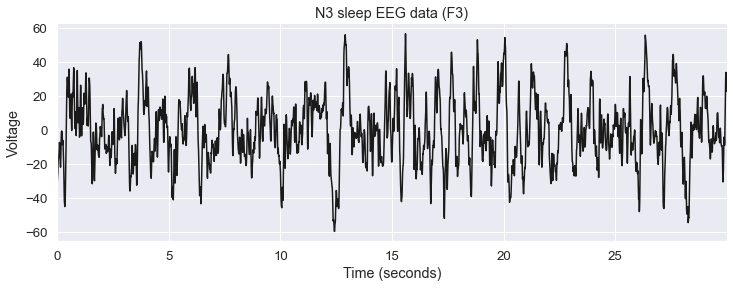

In [2]:
#let's look into the data
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

# Define sampling frequency and time vector
sf = 100.
time = np.arange(data.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([time.min(), time.max()])
plt.title('N3 sleep EEG data (F3)')
sns.despine()

## Computing the power spectral density
In order to compute the average bandpower in the delta band, we first need to compute an estimate of the power spectral density. The most widely-used method to do that is the Welch's periodogram, which consists in averaging consecutive Fourier transform of small windows of the signal, with or without overlapping.

The Welch's method improves the accuracy of the classic periodogram. The reason is simple: EEG data are always time-varying, meaning that if you look at a 30 seconds of EEG data, it is very (very) unlikely that the signal will looks like a perfect sum of pure sines. Rather, the spectral content of the EEG changes over time, constantly modified by the neuronal activity at play under the scalp. Problem is, to return a true spectral estimate, a classic periodogram requires the spectral content of the signal to be stationnary (i.e. time-unvarying) over the time period considered. Because it is never the case, the periodogram is generally biased and contains way too much variance (see the end of this tutorial). By averaging the periodograms obtained over short segments of the windows, the Welch's method allows to drastically reduce this variance. This comes at the cost, however, of a lower frequency resolution. Indeed, the frequency resolution is defined by:
                    **Δf = fs/N =fs/fs(t) = 1/t**
where 
fs
 is the sampling frequency of the signal, 
N
 the total number of samples and 
t
 the duration, in seconds, of the signal. In other words, if we were to use the full length of our data (30 seconds), our final frequency resolution would be 
1
/
30
=
0.033
 Hz, which is 30 frequency bins per Hertz. By using a 4-second sliding window, we reduce this frequency resolution to 4 frequency bins per Hertz, i.e. each step represents 0.25 Hz.

How do we define the optimal window duration then? A commonly used approach is to take a window sufficiently long to encompasses at least two full cycles of the lowest frequency of interest. In our case, our lowest frequency of interest is 0.5 Hz so we will choose a window of 
2
/
0.5
=
4
 seconds.

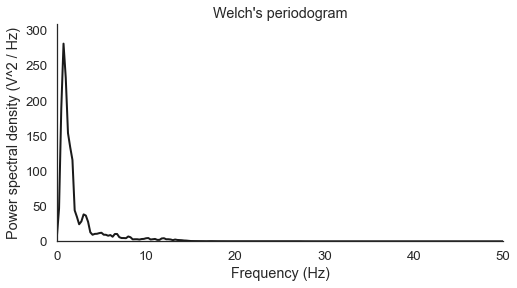

In [3]:
from scipy import signal

# Define window length (4 seconds)
win = 4 * sf
freqs, psd = signal.welch(data, sf, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

The freqs vector contains the x-axis (frequency bins) and the psd vector contains the y-axis (power spectral density). The units of the power spectral density, when working with EEG data, is usually micro-Volts-squared per Hz

### Defining the delta band
Now, before computing the average delta bandpower, we need to find the frequency bins that intersect the delta frequency range

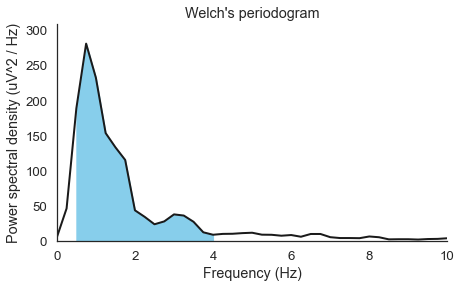

In [4]:
# Define delta lower and upper limits
low, high = 0.5, 4

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 10])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

### Average band power
The absolute delta power is equal to the blue area of the previous plot. As there is no closed-form formula to integrate this area, we need to approximate it. This is commonly achieved using the composite Simpson's rule. The idea behind it is actually very simple: we decompose this area into several parabola and then sum the area of these parabola. Note that this could also be done using trapezoid (trapezoid rule) or rectangle (as in the Matlab bandpower function), but parabola typically give better estimates.

In [5]:
from scipy.integrate import simps

# Frequency resolution
freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
delta_power = simps(psd[idx_delta], dx=freq_res)
print('Absolute delta power: %.3f uV^2' % delta_power)

Absolute delta power: 321.064 uV^2


### Relative power
In practice, rather than reporting the absolute band power, one may want to express the power in a frequency band as a percentage of the total power of the signal. This is called the relative band power. It can be calculated very easily from the above:

In [6]:
# Relative delta power (expressed as a percentage of total power)
total_power = simps(psd, dx=freq_res)
delta_rel_power = delta_power / total_power
print('Relative delta power: %.3f' % delta_rel_power)

Relative delta power: 0.787


In other words, 78.7% of the total power of the signal is contained in the delta frequency band.

### Generalization
The function below is a generalization of the above which can be used to easily get the average absolute or relative power in a specific frequency band. It is very similar to the Matlab bandpower function, with the exceptions that it uses a Welch's periodogram instead of a classical periodogram, and it approximates the area using parabola instead of rectangles.

In [7]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

### Ratio between two frequency bands
It is also very common to report the ratios between two frequency bands. For instance, the delta / beta ratio is a well-known index of slow-wave sleep quality. When computing ratios between two bands, it is important to control that the window length of the periodogram is the same for the two bands. Indeed, if you are using a different window length for the two bands, this will result in two different periodograms and the ratio will therefore be meaningless.

In [8]:
# Define the duration of the window to be 4 seconds
win_sec = 4

# Delta/beta ratio based on the absolute power
db = bandpower(data, sf, [0.5, 4], win_sec) / bandpower(data, sf, [12, 30], win_sec)

# Delta/beta ratio based on the relative power
db_rel = bandpower(data, sf, [0.5, 4], win_sec, True) / bandpower(data, sf, [12, 30], win_sec, True)

print('Delta/beta ratio (absolute): %.3f' % db)
print('Delta/beta ratio (relative): %.3f' % db_rel)

Delta/beta ratio (absolute): 42.214
Delta/beta ratio (relative): 42.214


### Using the multitaper method
Multitaper is a spectral analysis method first developed by David J. Thompson in 1982 in order to overcome some of the limitations of the classical spectral estimation techniques. It provides a more robust spectral estimation than the classical and Welch's periodograms, by combining the advantages of the two methods: high frequency resolution and low variance.

In a nutshell, the multitaper method starts by filtering the original signal with a set of optimal bandpass filter, called Slepian sequences (or DPSS). This filtering is done by convoluting the original signal with the Slepian sequences. Second, a classic periodogram is calculated for each of these new filtered (or "tapered") data and the final spectrum is then obtained by averaging over all the resulting periodogram. The real strength of the multitaper method comes from the fact that the Slepian sequences are orthogonal to all others and therefore the tapered signals provide statistically independent estimates of the underlying spectrum. In other words, each filtered signal will highlight one specific aspect of the spectral content of the signal.
<img src="https://raphaelvallat.com/images/tutorials/bandpower/prerau_article.jpg" width="800" alt="EEG FRequancy bands"  />

### Average bandpower using Multitaper
The multitaper spectral estimation method is implemented in the MNE-Python package. In the following example, I adapted the bandpower function that we have created previously to add the multitaper method.

In [11]:
def bandpower(data, sf, band, method='welch', window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
      Input signal in the time-domain.
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    band = np.asarray(band)
    low, high = band

    # Compute the modified periodogram (Welch)
    if method == 'welch':
        if window_sec is not None:
            nperseg = window_sec * sf
        else:
            nperseg = (2 / low) * sf

        freqs, psd = welch(data, sf, nperseg=nperseg)

    elif method == 'multitaper':
        psd, freqs = psd_array_multitaper(data, sf, adaptive=True,
                                          normalization='full', verbose=0)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

Let's try our new function with the code below. One advantage of the Multitaper method compared to the Welch's method is that we do not need to specify a window duration as it will basically compute the periodogram on the whole signal. Since we are using the full length of the signal, the frequency resolution of the multitaper estimate will be 1 / 30 = 0.033 Hz

In [12]:
# Multitaper delta power
bp = bandpower(data, sf, [0.5, 4], 'multitaper')
bp_rel = bandpower(data, sf, [0.5, 4], 'multitaper', relative=True)
print('Absolute delta power: %.3f' % bp)
print('Relative delta power: %.3f' % bp_rel)

# Delta-beta ratio
# One advantage of the multitaper is that we don't need to define a window length.
db = bandpower(data, sf, [0.5, 4], 'multitaper') / bandpower(data, sf, [12, 30], 'multitaper')
# Ratio based on the relative power
db_rel = bandpower(data, sf, [0.5, 4], 'multitaper', relative=True) / \
                    bandpower(data, sf, [12, 30], 'multitaper', relative=True)
print('Delta/beta ratio (absolute): %.3f' % db)
print('Delta/beta ratio (relative): %.3f' % db_rel)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

Absolute delta power: 311.555
Relative delta power: 0.790
Delta/beta ratio (absolute): 41.228
Delta/beta ratio (relative): 41.228


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


The results are very close to the one obtained using Welch's method. This should remain true as long as your data are not too noisy. However, if you are working with noisy data, the multitaper method will always provide a much more robust spectral estimation than Welch's.

Just for fun, let's compare the power spectral density estimate obtained using a classic periodogram, a Welch's periodogram, and the multitaper method:

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


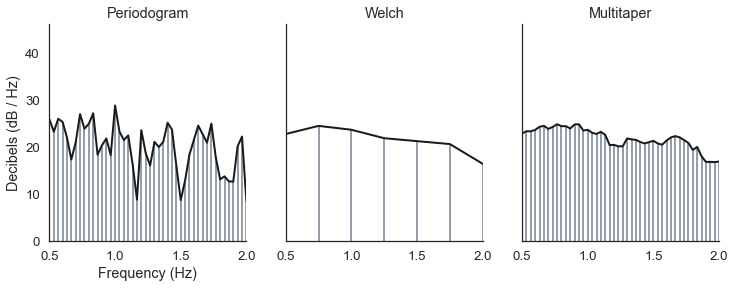

In [13]:
def plot_spectrum_methods(data, sf, window_sec, band=None, dB=False):
    """Plot the periodogram, Welch's and multitaper PSD.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds for Welch's PSD
    dB : boolean
        If True, convert the power to dB.
    """
    from mne.time_frequency import psd_array_multitaper
    from scipy.signal import welch, periodogram
    sns.set(style="white", font_scale=1.2)
    # Compute the PSD
    freqs, psd = periodogram(data, sf)
    freqs_welch, psd_welch = welch(data, sf, nperseg=window_sec*sf)
    psd_mt, freqs_mt = psd_array_multitaper(data, sf, adaptive=True,
                                            normalization='full', verbose=0)
    sharey = False

    # Optional: convert power to decibels (dB = 10 * log10(power))
    if dB:
        psd = 10 * np.log10(psd)
        psd_welch = 10 * np.log10(psd_welch)
        psd_mt = 10 * np.log10(psd_mt)
        sharey = True

    # Start plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=sharey)
    # Stem
    sc = 'slategrey'
    ax1.stem(freqs, psd, linefmt=sc, basefmt=" ", markerfmt=" ")
    ax2.stem(freqs_welch, psd_welch, linefmt=sc, basefmt=" ", markerfmt=" ")
    ax3.stem(freqs_mt, psd_mt, linefmt=sc, basefmt=" ", markerfmt=" ")
    # Line
    lc, lw = 'k', 2
    ax1.plot(freqs, psd, lw=lw, color=lc)
    ax2.plot(freqs_welch, psd_welch, lw=lw, color=lc)
    ax3.plot(freqs_mt, psd_mt, lw=lw, color=lc)
    # Labels and axes
    ax1.set_xlabel('Frequency (Hz)')
    if not dB:
        ax1.set_ylabel('Power spectral density (V^2/Hz)')
    else:
        ax1.set_ylabel('Decibels (dB / Hz)')
    ax1.set_title('Periodogram')
    ax2.set_title('Welch')
    ax3.set_title('Multitaper')
    if band is not None:
        ax1.set_xlim(band)
    ax1.set_ylim(ymin=0)
    ax2.set_ylim(ymin=0)
    ax3.set_ylim(ymin=0)
    sns.despine()

# Example: plot the 0.5 - 2 Hz band
plot_spectrum_methods(data, sf, 4, [0.5, 2], dB=True)

* The classic periodogram has a good frequency resolution (one frequency bin = 0.033 Hz) but way too much variance.
* The Welch's periodogram has a low variance, at the cost of a lower frequency resolution (one frequency bin = 0.25 Hz).
* The multitaper periodogram has the advantages of the two previous methods: high frequency resolution and low variance.

In [14]:
#Computational cost
%timeit bandpower(data, sf, [0.5, 4], method="welch", relative=True)
%timeit bandpower(data, sf, [0.5, 4], method="multitaper", relative=True)

1.13 ms ± 70.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

68.5 ms ± 27.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


The multitaper is more computationally intensive than other methods. In the example above, the multitaper method was about 300 times slower than the Welch's method. Using 30-sec of data sampled at 100 Hz, the difference in the time of execution was about ~100ms. Now, imagine that you have several hours of data and several channels sampled at 1000 Hz; what was barely perceptible on our 30-sec data could turn into a difference of several hours (e.g. 1 min for Welch, ~5 hours for the multitaper). This is definitely something that you may want to consider when deciding which method to use.

Second, although the multitaper methods always provide a more robust spectral estimation, I think that choosing which technique one should use depends on the data at hands. For example, if you have clean data acquired on young healthy individuals, there's a good chance that the multitaper spectral estimation will not differ that much from the Welch's estimate. Furthermore, the Welch's method is probably the most used spectral estimation technique to this day and is quite intuitive to understand. By contrast, the multitaper is a relatively new method that is conceptually harder to grasp.
 